Saved plot to trajectories_bold.png


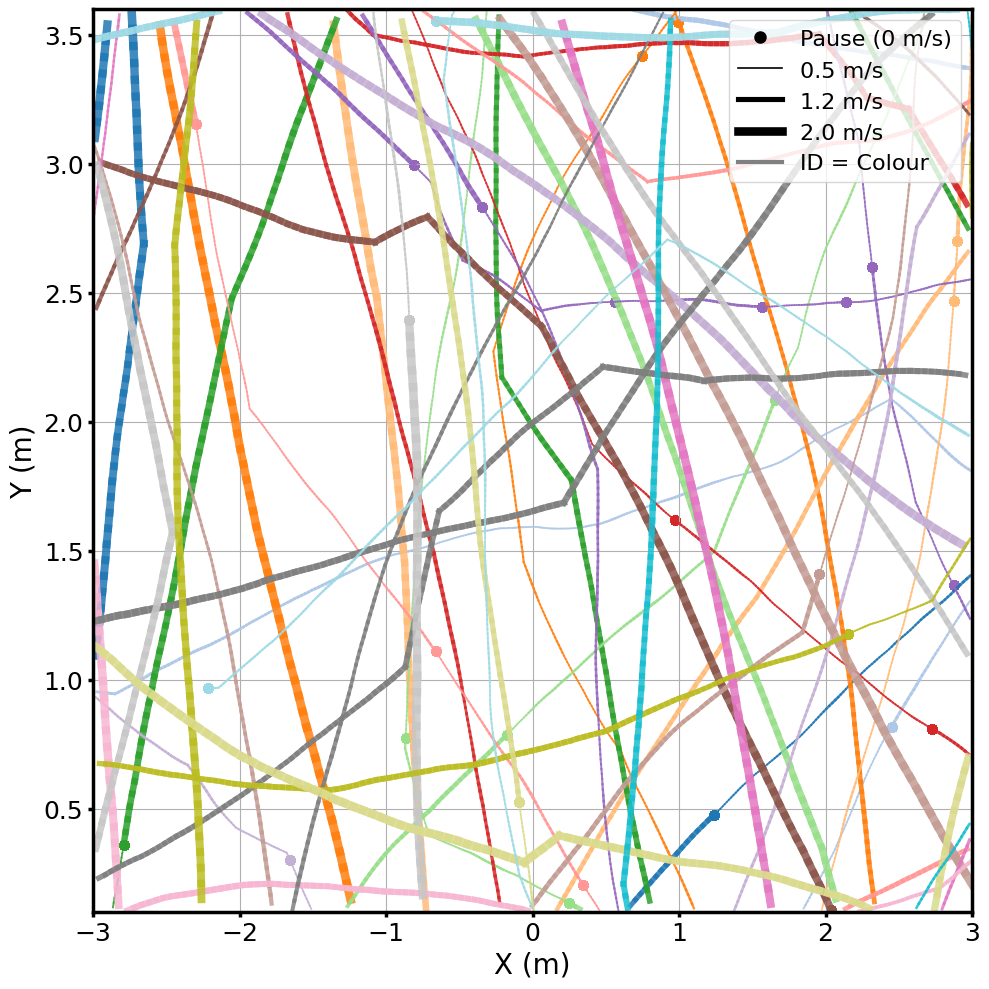

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------------------------
# Simulation parameters
# ------------------------
X_MIN, X_MAX = -3.0, 3.0
Y_MIN, Y_MAX = 0.1, 3.6
FPS = 30
DT = 1.0 / FPS
TOTAL_SECONDS = 5 * 60
N_FRAMES = int(TOTAL_SECONDS * FPS)

# ------------------------
# Motion parameters
# ------------------------
SPEED_MIN = 0.5
SPEED_MAX = 2.0
SPEED_SIGMA = 0.02
HEADING_SIGMA = 0.02
P_TURN = 0.01
MAX_TURN = np.pi / 4
P_PAUSE = 0.005
PAUSE_MIN = 2
PAUSE_MAX = 20
SPAWN_MIN = 2
SPAWN_MAX = 8

records = []
agents = {}
next_spawn_time = 0.0
next_id = 1

def spawn_pedestrian(t):
    global next_id, next_spawn_time
    pid = next_id
    next_id += 1
    next_spawn_time = t + np.random.uniform(SPAWN_MIN, SPAWN_MAX)
    edge = np.random.choice(['left', 'right', 'bottom', 'top'])
    if edge == 'left':
        x, y = X_MIN, np.random.uniform(Y_MIN, Y_MAX)
        heading = np.random.uniform(-np.pi / 2, np.pi / 2)
    elif edge == 'right':
        x, y = X_MAX, np.random.uniform(Y_MIN, Y_MAX)
        heading = np.random.uniform(np.pi / 2, 3 * np.pi / 2)
    elif edge == 'bottom':
        x, y = np.random.uniform(X_MIN, X_MAX), Y_MIN
        heading = np.random.uniform(0, np.pi)
    else:
        x, y = np.random.uniform(X_MIN, X_MAX), Y_MAX
        heading = np.random.uniform(-np.pi, 0)
    speed = np.random.uniform(SPEED_MIN, SPEED_MAX)
    agents[pid] = {'x': x, 'y': y, 'heading': heading, 'speed': speed,
                   'first_frame': True, 'pause_active': False,
                   'pause_remaining': 0, 'vx': 0.0, 'vy': 0.0}

# Simulation loop
for frame in range(N_FRAMES):
    t = frame * DT
    if t >= next_spawn_time:
        spawn_pedestrian(t)
    for pid in list(agents):
        a = agents[pid]
        if a['first_frame']:
            a['first_frame'] = False
            continue
        if a['pause_active']:
            a['pause_remaining'] -= 1
            if a['pause_remaining'] <= 0:
                a['pause_active'] = False
            a['vx'], a['vy'], a['speed'] = 0.0, 0.0, 0.0
        elif np.random.rand() < P_PAUSE:
            a['pause_active'] = True
            a['pause_remaining'] = np.random.randint(PAUSE_MIN * FPS, PAUSE_MAX * FPS)
            a['vx'], a['vy'], a['speed'] = 0.0, 0.0, 0.0
        else:
            a['heading'] += np.random.normal(0, HEADING_SIGMA)
            if np.random.rand() < P_TURN:
                a['heading'] += np.random.uniform(-MAX_TURN, MAX_TURN)
            a['speed'] += np.random.normal(0, SPEED_SIGMA)
            a['speed'] = np.clip(a['speed'], SPEED_MIN, SPEED_MAX)
            a['vx'] = a['speed'] * np.cos(a['heading'])
            a['vy'] = a['speed'] * np.sin(a['heading'])
            a['x'] += a['vx'] * DT
            a['y'] += a['vy'] * DT
        if not (X_MIN <= a['x'] <= X_MAX and Y_MIN <= a['y'] <= Y_MAX):
            del agents[pid]
            continue
        records.append({'time_s': t, 'ped_id': pid, 'x': a['x'], 'y': a['y'], 'vx': a['vx'], 'vy': a['vy'], 'speed': a['speed']})

# DataFrame
df = pd.DataFrame(records)

# Plot
plt.figure(figsize=(10, 10))
ax = plt.gca()
unique_peds = df['ped_id'].unique()
cmap = plt.get_cmap('tab20', len(unique_peds))
colors = {pid: cmap(i) for i, pid in enumerate(unique_peds)}

def lw_from_speed(s):
    return 1.2 + ((s - SPEED_MIN) / (SPEED_MAX - SPEED_MIN) if s > 0 else 0) * 5.0  # Thicker lines

for pid, group in df.groupby('ped_id'):
    xs, ys, speeds = group['x'], group['y'], group['speed']
    c = colors[pid]
    for i in range(len(xs) - 1):
        ax.plot(xs.values[i:i + 2], ys.values[i:i + 2], color=c,
                linewidth=lw_from_speed(speeds.values[i]), alpha=0.85)
    paused = group[group['speed'] == 0.0]
    if not paused.empty:
        ax.scatter(paused['x'], paused['y'], c=[c], s=40, marker='o')  # Bigger pause markers

# Axis limits
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)

# Axis labels with bold and larger font
ax.set_xlabel('X (m)', fontsize=20, fontweight='normal')
ax.set_ylabel('Y (m)', fontsize=20, fontweight='normal')

# Ticks - bigger, bold
ax.tick_params(axis='both', which='major', labelsize=18, width=2.5)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('normal')

# Axis spines - thicker
for spine in ax.spines.values():
    spine.set_linewidth(2.5)

# Legend adjustments
legend_handles = []
legend_handles.append(Line2D([0], [0], color='k', marker='o', linestyle='None', markersize=8,
                            label='Pause (0 m/s)'))
for s in [SPEED_MIN, (SPEED_MIN + SPEED_MAX) / 2, SPEED_MAX]:
    legend_handles.append(Line2D([0], [0], color='k', linewidth=lw_from_speed(s),
                                label=f'{s:.1f} m/s'))
legend_handles.append(Line2D([0], [0], color='grey', linewidth=3, label='ID = Colour'))

# no title, normal weight text
ax.legend(handles=legend_handles,
          loc='upper right',
          fontsize=16)

plt.grid(True)
plt.tight_layout()

# Save
output_path = 'trajectories_bold.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_path}")
plt.show()
